In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

import xgboost

In [3]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) Read in data & explore preliminarily

In [4]:
df = pd.read_csv('home_sales_dataset.csv')
print(df.shape)
df.head()

(1011, 18)


sold_price  beds  baths  hm_sqft  lot_size  yr_built  zipcode  pool  \
0      970000     4    3.0     1933      6999      1960    91364     1   
1      900000     3    2.0     1519     11761      1974    91304     1   
2      830000     3    2.0     1595     10560      1960    91303     1   
3      820000     3    2.5     1364      7253      1959    91307     0   
4      940553     4    2.5     2018      9347      1960    91367     1   

   garage  stories  schools       sold_date             address  days_on_mkt  \
0       1        1      6.4  August-24-2021  22247 De La Osa St            3   
1       1        1      6.4  August-24-2021      7631 Atron Ave            3   
2       1        1      4.8  August-23-2021    22221 Vanowen St            4   
3       0        1      7.0  August-23-2021  23433 Victory Blvd            4   
4       1        1      6.8  August-23-2021     23952 Oxnard St            4   

   hoa                                                url        lat  \
0    0  http://www.redfin.com/CA/Woodland-Hills/22247-...  34.159168   
1    0  http://www.redfin.com/CA/Canoga-Park/7631-Atro...  34.209223   
2    0  http://www.redfin.com/CA/Canoga-Park/22221-Van...  34.193982   
3    0  http://www.redfin.com/CA/West-Hills/23433-Vict...  34.186740   
4    0  http://www.redfin.com/CA/Woodland-Hills/23952-...  34.179507   

          lon  
0 -118.611596  
1 -118.637737  
2 -118.611141  
3 -118.637805  
4 -118.649017

In [5]:
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [6]:
df.head()

sold_price  beds  baths  hm_sqft  lot_size  yr_built  zipcode  pool  \
0      970000     4    3.0     1933      6999      1960    91364     1   
1      900000     3    2.0     1519     11761      1974    91304     1   
2      830000     3    2.0     1595     10560      1960    91303     1   
3      820000     3    2.5     1364      7253      1959    91307     0   
4      940553     4    2.5     2018      9347      1960    91367     1   

   garage  stories  schools  sold_date             address  days_on_mkt  hoa  \
0       1        1      6.4 2021-08-24  22247 De La Osa St            3    0   
1       1        1      6.4 2021-08-24      7631 Atron Ave            3    0   
2       1        1      4.8 2021-08-23    22221 Vanowen St            4    0   
3       0        1      7.0 2021-08-23  23433 Victory Blvd            4    0   
4       1        1      6.8 2021-08-23     23952 Oxnard St            4    0   

                                                 url        lat         lon  
0  http://www.redfin.com/CA/Woodland-Hills/22247-...  34.159168 -118.611596  
1  http://www.redfin.com/CA/Canoga-Park/7631-Atro...  34.209223 -118.637737  
2  http://www.redfin.com/CA/Canoga-Park/22221-Van...  34.193982 -118.611141  
3  http://www.redfin.com/CA/West-Hills/23433-Vict...  34.186740 -118.637805  
4  http://www.redfin.com/CA/Woodland-Hills/23952-...  34.179507 -118.649017

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sold_price   1011 non-null   int64         
 1   beds         1011 non-null   int64         
 2   baths        1011 non-null   float64       
 3   hm_sqft      1011 non-null   int64         
 4   lot_size     1011 non-null   int64         
 5   yr_built     1011 non-null   int64         
 6   zipcode      1011 non-null   int64         
 7   pool         1011 non-null   int64         
 8   garage       1011 non-null   int64         
 9   stories      1011 non-null   int64         
 10  schools      1011 non-null   float64       
 11  sold_date    1011 non-null   datetime64[ns]
 12  address      1011 non-null   object        
 13  days_on_mkt  1011 non-null   int64         
 14  hoa          1011 non-null   int64         
 15  url          1011 non-null   object        
 16  lat   

In [8]:
df.drop(columns=['zipcode', 'lat', 'lon']).describe()

sold_price         beds        baths      hm_sqft       lot_size  \
count  1.011000e+03  1011.000000  1011.000000  1011.000000    1011.000000   
mean   1.126206e+06     3.633037     2.544510  2081.720079   10828.724036   
std    5.022851e+05     0.844819     0.924634   886.574023   15533.545033   
min    4.000000e+05     1.000000     1.000000   552.000000    2000.000000   
25%    8.400000e+05     3.000000     2.000000  1471.000000    7083.000000   
50%    9.650000e+05     4.000000     2.000000  1873.000000    8217.000000   
75%    1.260000e+06     4.000000     3.000000  2447.000000   11761.000000   
max    5.500000e+06     8.000000     8.000000  8189.000000  475675.000000   

          yr_built         pool       garage      stories      schools  \
count  1011.000000  1011.000000  1011.000000  1011.000000  1011.000000   
mean   1960.297725     0.134520     0.140455     1.178042     5.738731   
std      11.616964     0.341379     0.347630     0.387876     0.674897   
min    1920.000000     0.000000     0.000000     1.000000     4.200000   
25%    1954.000000     0.000000     0.000000     1.000000     5.200000   
50%    1958.000000     0.000000     0.000000     1.000000     5.666667   
75%    1964.000000     0.000000     0.000000     1.000000     6.166667   
max    2021.000000     1.000000     1.000000     3.000000     7.666667   

       days_on_mkt          hoa  
count  1011.000000  1011.000000  
mean     44.678536     2.430267  
std      24.281487    24.731666  
min       1.000000     0.000000  
25%      25.000000     0.000000  
50%      44.000000     0.000000  
75%      64.000000     0.000000  
max      90.000000   585.000000

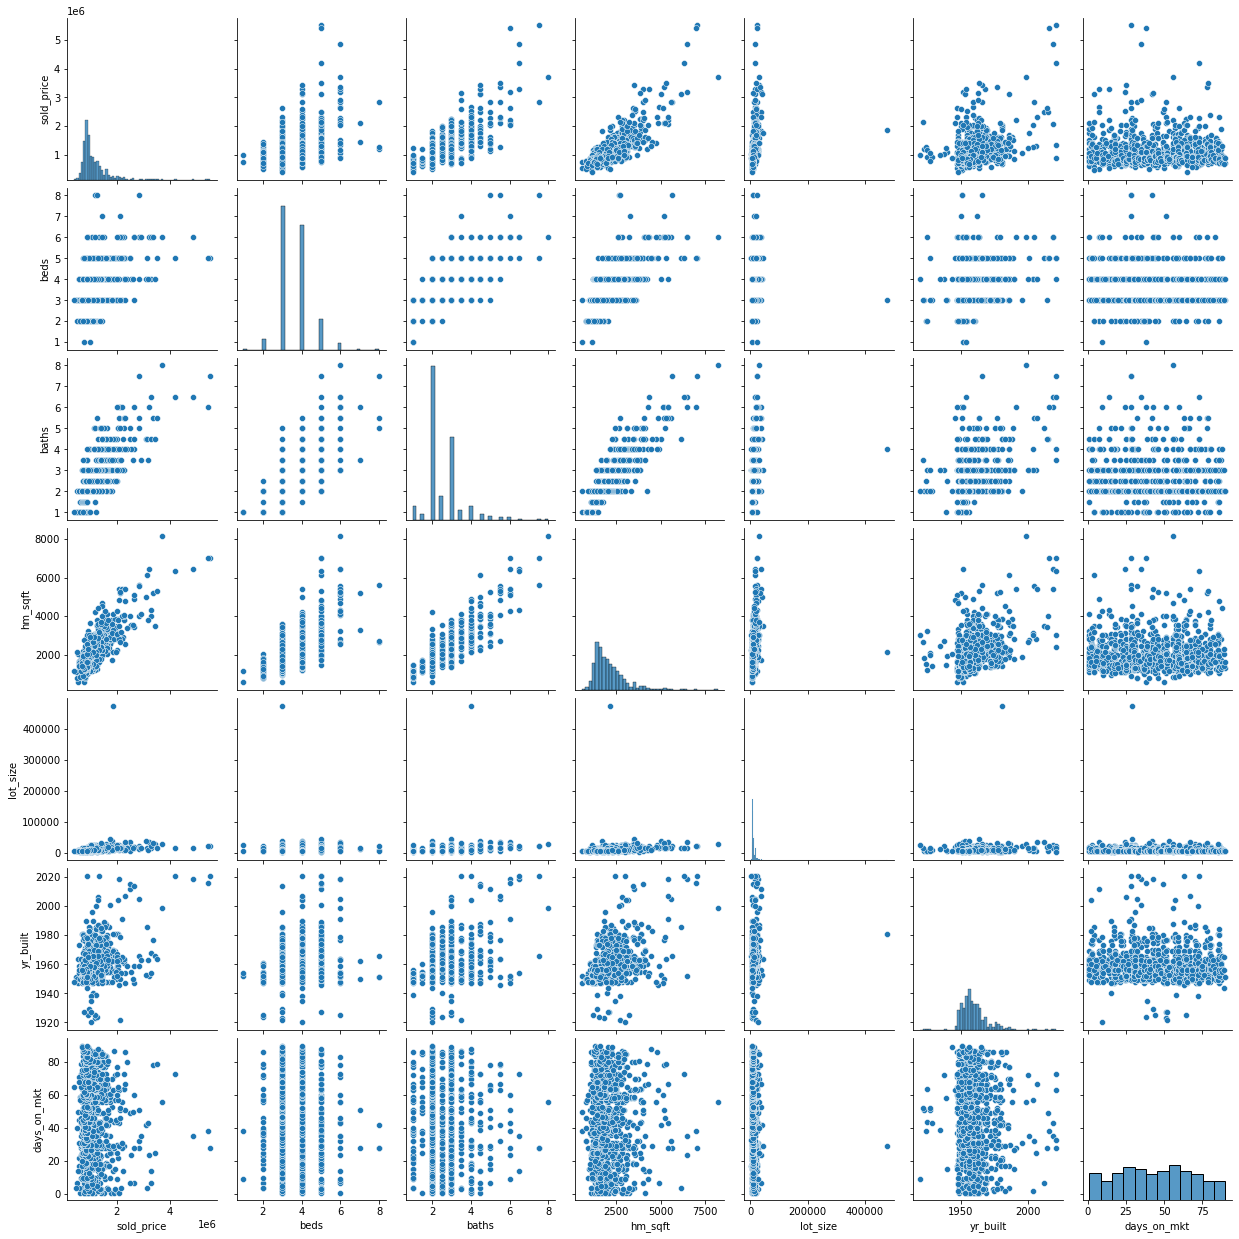

In [9]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']);

#### Drop that one home with a huge lot_size from the dataset (obvious undesirable outlier, not representative of vast majority)

In [10]:
print(df.shape)
df = df[df['lot_size'] < 200000]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(1011, 18)
(1010, 18)


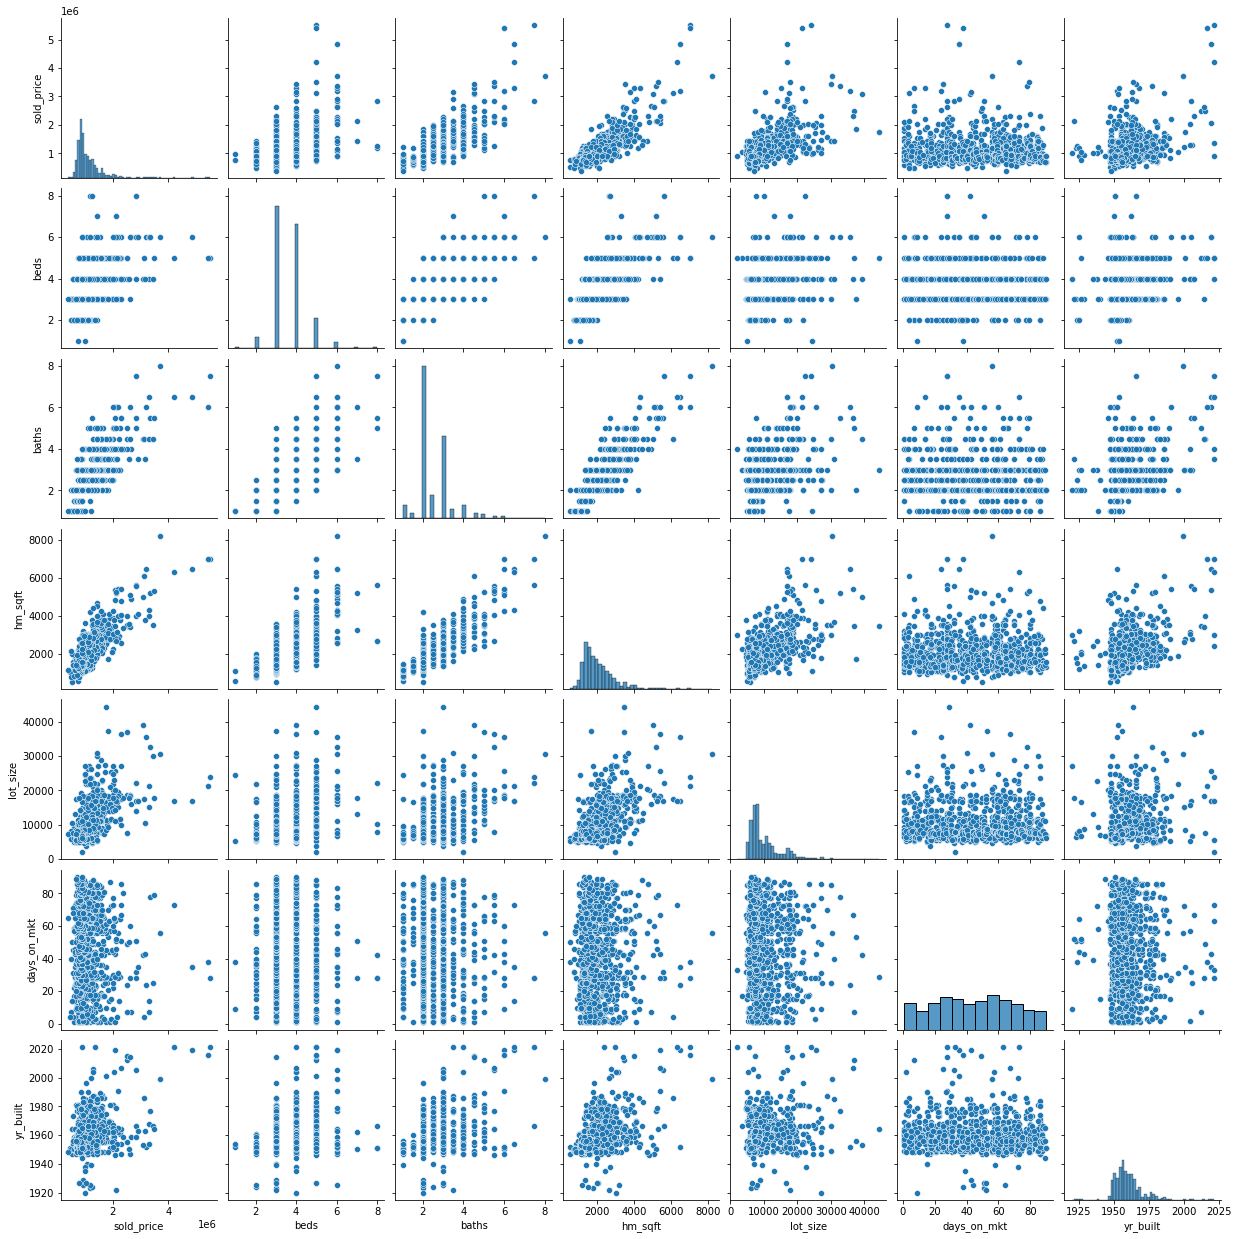

In [11]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'days_on_mkt', 'yr_built']);

In [12]:
df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']].corr()

sold_price      beds     baths   hm_sqft  lot_size  yr_built  \
sold_price     1.000000  0.468586  0.747992  0.836873  0.616309  0.405557   
beds           0.468586  1.000000  0.677780  0.673701  0.353676  0.330157   
baths          0.747992  0.677780  1.000000  0.853740  0.506800  0.425517   
hm_sqft        0.836873  0.673701  0.853740  1.000000  0.611860  0.482993   
lot_size       0.616309  0.353676  0.506800  0.611860  1.000000  0.235796   
yr_built       0.405557  0.330157  0.425517  0.482993  0.235796  1.000000   
days_on_mkt   -0.015035 -0.003969 -0.003983 -0.012386 -0.011387 -0.031676   

             days_on_mkt  
sold_price     -0.015035  
beds           -0.003969  
baths          -0.003983  
hm_sqft        -0.012386  
lot_size       -0.011387  
yr_built       -0.031676  
days_on_mkt     1.000000

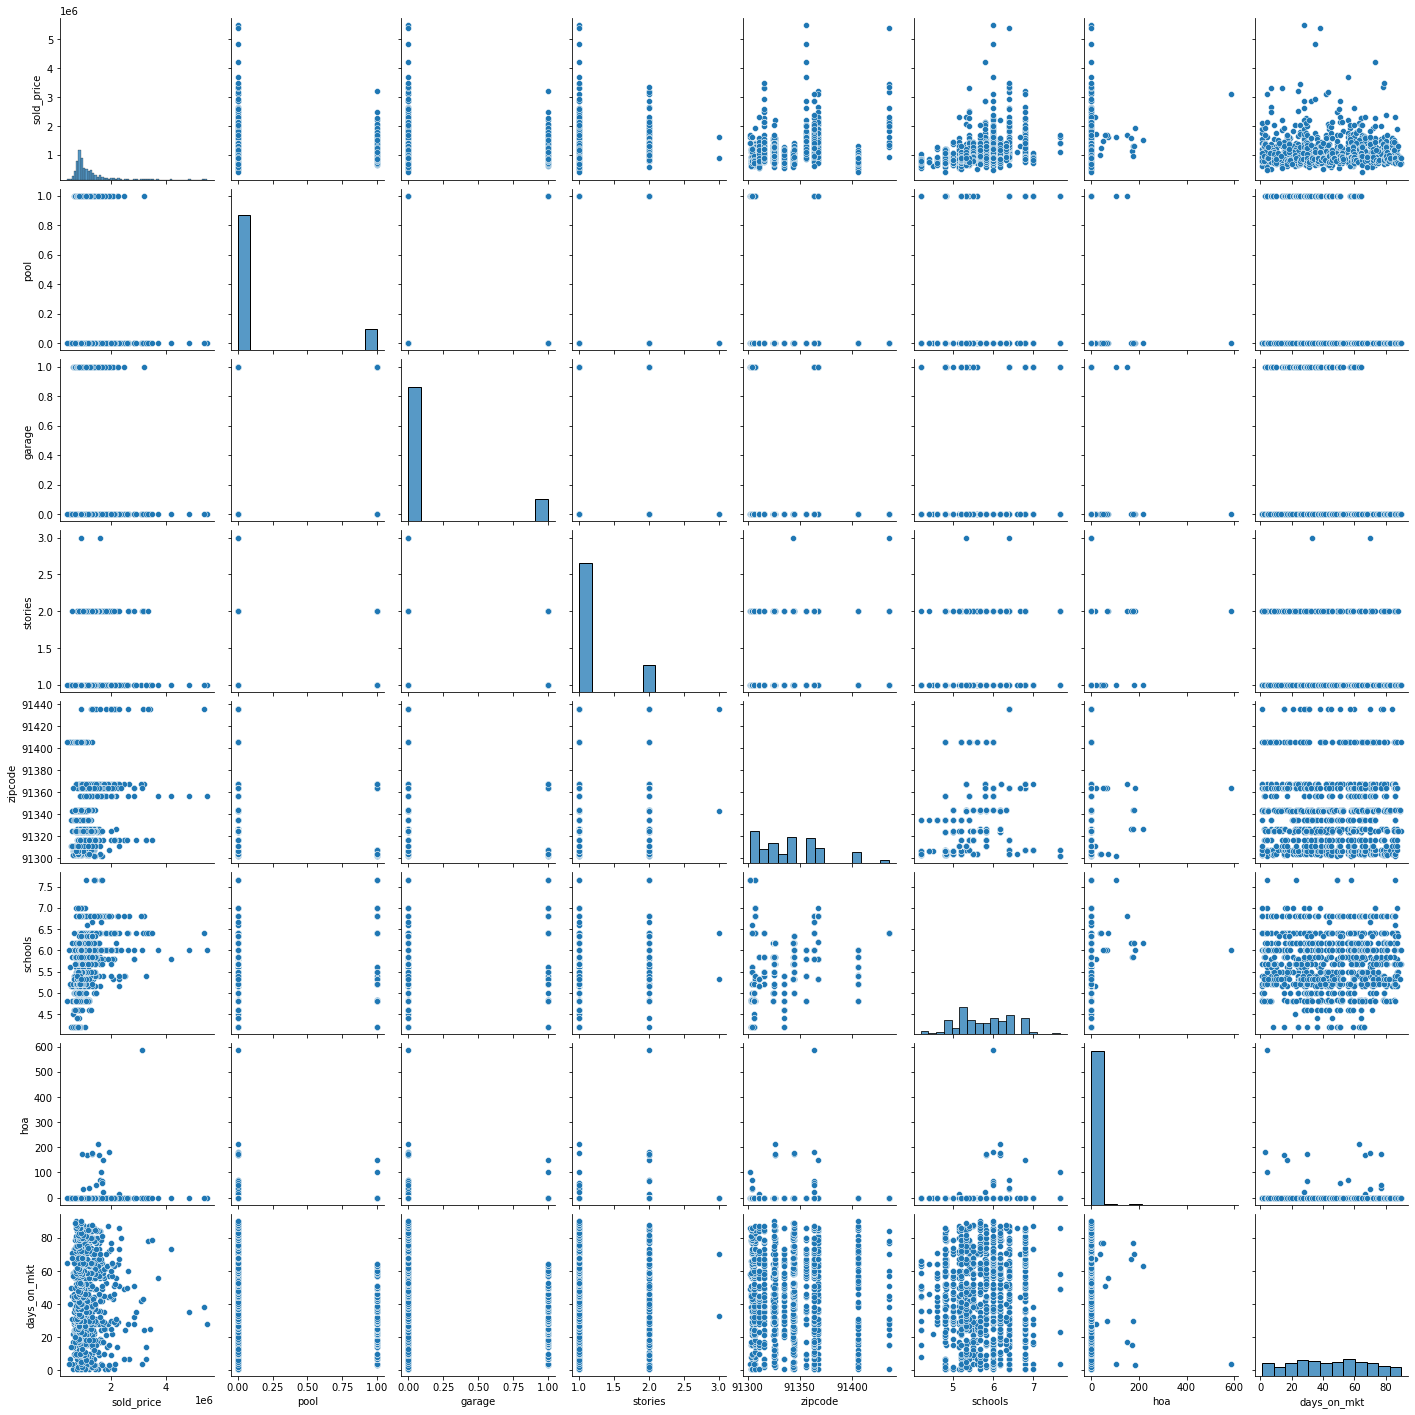

In [13]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']);

In [14]:
df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']].corr()

sold_price      pool    garage   stories   zipcode   schools  \
sold_price     1.000000  0.028298  0.025144  0.187080  0.219329  0.356463   
pool           0.028298  1.000000  0.950247  0.074175 -0.100235  0.268048   
garage         0.025144  0.950247  1.000000  0.057655 -0.096038  0.280840   
stories        0.187080  0.074175  0.057655  1.000000 -0.028739  0.177494   
zipcode        0.219329 -0.100235 -0.096038 -0.028739  1.000000  0.267983   
schools        0.356463  0.268048  0.280840  0.177494  0.267983  1.000000   
hoa            0.143552 -0.009247 -0.010762  0.136809  0.006319  0.061756   
days_on_mkt   -0.015035 -0.219170 -0.225222 -0.051873 -0.012574 -0.026134   

                  hoa  days_on_mkt  
sold_price   0.143552    -0.015035  
pool        -0.009247    -0.219170  
garage      -0.010762    -0.225222  
stories      0.136809    -0.051873  
zipcode      0.006319    -0.012574  
schools      0.061756    -0.026134  
hoa          1.000000    -0.042238  
days_on_mkt -0.042238     1.000000

#### Early conclusion: days_on_mkt (and alternative target) is uniformly distributed & pretty much uncorrelated w/ everything else!

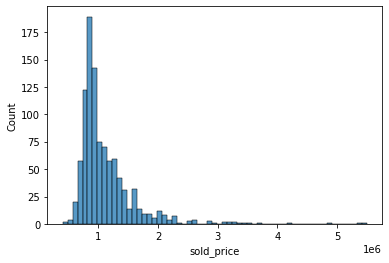

In [15]:
sns.histplot(data=df['sold_price']);

#### Perhaps log transforming the target can lead to a better model

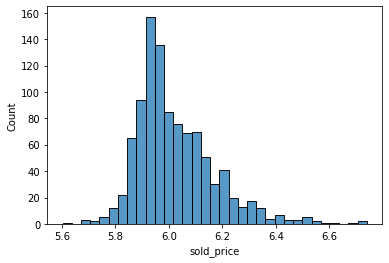

In [16]:
sns.histplot(data=np.log10(df['sold_price']));

# 2) Feature Engineering (part 1)

### Given the high VIFs with 1-hot zips, let's try grouping zipcodes into 'cities' and 1-hot that instead

In [17]:
df_data = df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 
              'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa']]

In [18]:
df_data['zipcode'].dtype

dtype('int64')

In [19]:
df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',
                                          91303: 'canoga_park',
                                          91304: 'canoga_park',
                                          91306: 'winnetka',
                                          91307: 'west_hills',
                                          91311: 'chatsworth',
                                          91316: 'encino',
                                          91324: 'northridge',
                                          91325: 'northridge',
                                          91326: 'porter_ranch',
                                          91335: 'reseda',
                                          91343: 'north_hills',
                                          91344: 'granada_hills',
                                          91356: 'tarzana',
                                          91364: 'woodland_hills',
                                          91367: 'woodland_hills',
                                          91406: 'lake_balboa',
                                          91436: 'encino'}
                                        )

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_54730/3655593410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',


In [20]:
df_data.drop(columns='zipcode')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sold_price  1010 non-null   int64  
 1   beds        1010 non-null   int64  
 2   baths       1010 non-null   float64
 3   hm_sqft     1010 non-null   int64  
 4   lot_size    1010 non-null   int64  
 5   yr_built    1010 non-null   int64  
 6   pool        1010 non-null   int64  
 7   garage      1010 non-null   int64  
 8   stories     1010 non-null   int64  
 9   zipcode     1010 non-null   int64  
 10  schools     1010 non-null   float64
 11  hoa         1010 non-null   int64  
 12  city        1010 non-null   object 
dtypes: float64(2), int64(10), object(1)
memory usage: 102.7+ KB


In [21]:
df_data = pd.get_dummies(df_data, columns=['city'], drop_first=True)
df_data.drop(columns='zipcode', inplace=True)

### Change 'stories' to binary variable 'one_story' (1 = yes, 0 = no => multi-story)

In [22]:
df_data['stories'].value_counts()

1    833
2    175
3      2
Name: stories, dtype: int64

In [23]:
df_data.loc[df_data['stories'] > 1, 'stories'] = 0
df_data.rename(columns={'stories': 'one_story'}, inplace=True)
df_data.head()

sold_price  beds  baths  hm_sqft  lot_size  yr_built  pool  garage  \
0      970000     4    3.0     1933      6999      1960     1       1   
1      900000     3    2.0     1519     11761      1974     1       1   
2      830000     3    2.0     1595     10560      1960     1       1   
3      820000     3    2.5     1364      7253      1959     0       0   
4      940553     4    2.5     2018      9347      1960     1       1   

   one_story  schools  hoa  city_chatsworth  city_encino  city_granada_hills  \
0          1      6.4    0                0            0                   0   
1          1      6.4    0                0            0                   0   
2          1      4.8    0                0            0                   0   
3          1      7.0    0                0            0                   0   
4          1      6.8    0                0            0                   0   

   city_lake_balboa  city_north_hills  city_northridge  city_porter_ranch  \
0                 0                 0                0                  0   
1                 0                 0                0                  0   
2                 0                 0                0                  0   
3                 0                 0                0                  0   
4                 0                 0                0                  0   

   city_reseda  city_tarzana  city_west_hills  city_winnetka  \
0            0             0                0              0   
1            0             0                0              0   
2            0             0                0              0   
3            0             0                1              0   
4            0             0                0              0   

   city_woodland_hills  
0                    1  
1                    0  
2                    0  
3                    0  
4                    1

In [24]:
df_data['one_story'].value_counts()

1    833
0    177
Name: one_story, dtype: int64

# 3) Baseline Features for Modeling

#### Define a Diagnostic Plot Function 
##### (adapted from func of same name provided in Metis linear assumptions & testing notebook)

In [25]:
def diagnostic_plots(x, y, y_pred):    
    
#     print('RMSE: {}'.format(round(mean_squared_error(y, y_pred, squared=False), 3)))
#     print('MAE: {}'.format(round(mean_absolute_error(y, y_pred), 3)))
    
    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.plot([5.6, 6.54], [5.6, 6.54], color='r', linestyle='-')
    plt.title("Predicted vs. Actual Sale Price")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [26]:
def cv_rsquareds(x, y, model, cv):    
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('CV R-squareds: {}'.format(scores)) 
    print('Mean CV R-squared: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))
    
    n = x.shape[0]
    p = x.shape[1]
    adj_r_squareds = [round(1 - (1 - r_squared)*((n - 1)/(n - p - 1)), 3) for r_squared in scores]
    print('\nAdjusted CV R-squareds: {}'.format(adj_r_squareds))
    print('Mean Adjusted CV R-squared: {} +/- {}'.format(round(np.mean(adj_r_squareds), 3), 
                                                         round(np.std(adj_r_squareds), 3)))

In [27]:
# This function inverts the log transform on y_pred and y prior so that MAE can be computed in dollars

def mae_for_log_y(y, y_pred):
    return mean_absolute_error(10**y, 10**y_pred)

scorer = make_scorer(mae_for_log_y, greater_is_better=False)

In [28]:
def cv_maes(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring=scorer, cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV MAEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV MAE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

### Split into CV and Test Sets (will NOT touch Test set until final model has been chosen and tuned!)

In [29]:
X = df_data.drop(columns='sold_price')
y = np.log10(df_data['sold_price'])

In [30]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model 1: Linear Model, all features

In [31]:
model_1 = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1, 5)
cv_maes(X_cv, y_cv, model_1, 5)

CV R-squareds: [0.822, 0.832, 0.836, 0.854, 0.842]
Mean CV R-squared: 0.837 +/- 0.011

Adjusted CV R-squareds: [0.817, 0.827, 0.831, 0.85, 0.838]
Mean Adjusted CV R-squared: 0.833 +/- 0.011

CV MAEs: [155512, 118132, 116949, 121273, 114859]
Mean CV MAE: 125345 +/- 15226


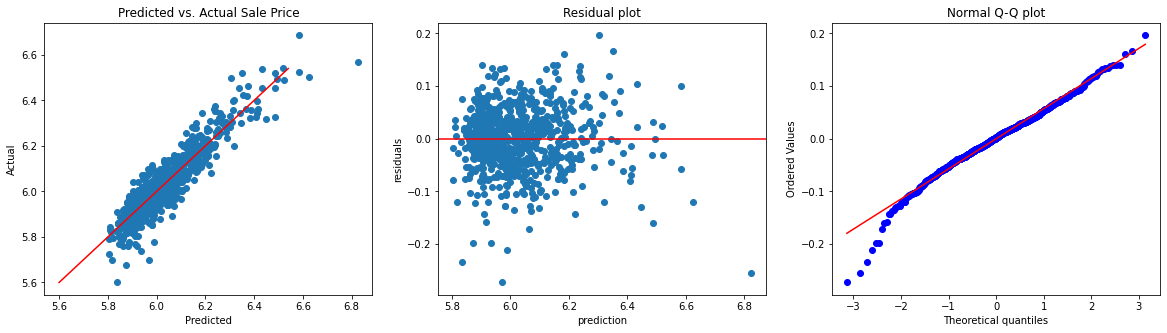

In [32]:
model_1.fit(X_cv, y_cv)

y_pred = model_1.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

#### Are the two highest priced predictions  influential points? Let's refit this using statsmodels to find out:

In [33]:
x_cv = sm.add_constant(X_cv)
model = sm.OLS(y_cv, x_cv)
model_1b = model.fit()
model_1b.summary()

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     198.3
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          1.49e-302
Time:                        16:44:23   Log-Likelihood:                 1161.0
No. Observations:                 808   AIC:                            -2276.
Df Residuals:                     785   BIC:                            -2168.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.1318      0.435     11.809      0.000       4.279       5.985
beds                   -0.0024      0.004     -0.640      0.522      -0.010       0.005
baths                   0.0239      0.005      5.277      0.000       0.015       0.033
hm_sqft              7.617e-05    5.4e-06     14.099      0.000    6.56e-05    8.68e-05
lot_size             5.671e-06    5.3e-07     10.707      0.000    4.63e-06    6.71e-06
yr_built                0.0002      0.000      0.889      0.374      -0.000       0.001
pool                   -0.0045      0.020     -0.222      0.825      -0.044       0.035
garage                  0.0006      0.020      0.032      0.975      -0.039       0.040
one_story               0.0149      0.006      2.387      0.017       0.003       0.027
schools                 0.0364      0.005      7.537      0.000       0.027       0.046
hoa                  8.908e-05   7.79e-05      1.143      0.253   -6.39e-05       0.000
city_chatsworth        -0.0451      0.013     -3.492      0.001      -0.070      -0.020
city_encino             0.1261      0.012     10.783      0.000       0.103       0.149
city_granada_hills     -0.0249      0.010     -2.462      0.014      -0.045      -0.005
city_lake_balboa       -0.0176      0.011     -1.641      0.101      -0.039       0.003
city_north_hills       -0.0386      0.011     -3.378      0.001      -0.061      -0.016
city_northridge        -0.0137      0.011     -1.238      0.216      -0.036       0.008
city_porter_ranch      -0.0019      0.012     -0.158      0.875      -0.026       0.022
city_reseda             0.0004      0.011      0.038      0.969      -0.022       0.023
city_tarzana            0.0877      0.013      6.592      0.000       0.062       0.114
city_west_hills        -0.0240      0.012     -2.063      0.039      -0.047      -0.001
city_winnetka          -0.0230      0.013     -1.710      0.088      -0.049       0.003
city_woodland_hills     0.0378      0.010      3.688      0.000       0.018       0.058
==============================================================================
Omnibus:                       55.160   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.868
Skew:                          -0.428   Prob(JB):                     3.10e-25
Kurtosis:                       4.619   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
influence_frame = model_1b.get_influence().summary_frame()
influence_frame['cooks_d'].sort_values(ascending=False).head()

499    0.123343
743    0.020294
129    0.019623
587    0.018494
695    0.017898
Name: cooks_d, dtype: float64

##### Interesting: Some of these largest Cook's distances (while definitely < 5) are for extremely high or low priced properties

In [35]:
print(10**y_cv.loc[499])
print(10**y_cv.loc[743])
print(10**y_cv.loc[129])
print(10**y_cv.loc[587])
print(10**y_cv.loc[695])

3710000.000000002
499000.0000000003
2074999.9999999986
545000.0000000001
3161999.9999999995


In [36]:
df_data['sold_price'].describe()

count    1.010000e+03
mean     1.125490e+06
std      5.020166e+05
min      4.000000e+05
25%      8.400000e+05
50%      9.650000e+05
75%      1.260000e+06
max      5.500000e+06
Name: sold_price, dtype: float64

In [37]:
df[df_data['sold_price'] < 575000].shape[0]

6

In [38]:
df_data[df_data['sold_price'] >= 3e6].shape[0]

14

In [39]:
df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price'].describe()

count    9.900000e+02
mean     1.091561e+06
std      3.782013e+05
min      5.750000e+05
25%      8.400000e+05
50%      9.600000e+05
75%      1.250000e+06
max      2.919500e+06
Name: sold_price, dtype: float64

##### Command decision: 'sold_price' >= 3 million is almost 4-sigma from the mean, so let's just drop the 14 >= 3 million dollar homes
##### AND, 'sold_price" < 575k is even further from the mean than that, so let's also drop the 6 < 575k dollar homes
##### (i.e. This model is geared towards the much more common lower home prices, not the handful of very high-priced homes, and it's also
#####  geared toward those that have a "realistic" lower bound on prices - e.g., not something that's a teardown, former meth house, etc.)

#### While we're here, what about colinearity (VIF)?

In [40]:
variables = model_1b.model.exog

# Don't count the intercept! (index=0)
vifs = [variance_inflation_factor(variables, i) for i in range(1, variables.shape[1])]
list(zip(X_cv.columns, vifs))

[('beds', 2.3148128749207326),
 ('baths', 4.043471517332343),
 ('hm_sqft', 5.388832661032012),
 ('lot_size', 1.804812618293314),
 ('yr_built', 1.5541937438842295),
 ('pool', 11.55709054017307),
 ('garage', 11.693702898655935),
 ('one_story', 1.343850740615704),
 ('schools', 2.510301883327543),
 ('hoa', 1.0934388039308098),
 ('city_chatsworth', 1.4612584697994708),
 ('city_encino', 2.1620786184485126),
 ('city_granada_hills', 2.3727980763444694),
 ('city_lake_balboa', 1.9428917929050251),
 ('city_north_hills', 1.7670036533211684),
 ('city_northridge', 1.8548367675667148),
 ('city_porter_ranch', 2.009986217982023),
 ('city_reseda', 1.692616002511555),
 ('city_tarzana', 1.645057586080708),
 ('city_west_hills', 1.9691722555592364),
 ('city_winnetka', 1.3905932150645586),
 ('city_woodland_hills', 4.226194025443885)]

#### Note that the previous VIFs for the 'zipcode' 1-hots were way worse than these for the 'city' 1-hots!

In [41]:
df_data[['pool', 'garage']].corr()

pool    garage
pool    1.000000  0.950247
garage  0.950247  1.000000

In [42]:
df_data[['pool', 'garage']].value_counts()

pool  garage
0     0         865
1     1         133
0     1           9
1     0           3
dtype: int64

#### Aha! 'pool' & 'garage' are highly correlated (missed that in the pair plots); let's drop 'pool'

In [43]:
df_data = df_data.drop(columns='pool')

In [44]:
df_data.columns

Index(['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built',
       'garage', 'one_story', 'schools', 'hoa', 'city_chatsworth',
       'city_encino', 'city_granada_hills', 'city_lake_balboa',
       'city_north_hills', 'city_northridge', 'city_porter_ranch',
       'city_reseda', 'city_tarzana', 'city_west_hills', 'city_winnetka',
       'city_woodland_hills'],
      dtype='object')

#### Pare down the dataset (dropping extreme low and extreme high prices) and rebuild the model

In [45]:
X = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')
y = np.log10(df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price'])

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model_1c = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1c, 5)
cv_maes(X_cv, y_cv, model_1c, 5)

CV R-squareds: [0.843, 0.848, 0.835, 0.799, 0.801]
Mean CV R-squared: 0.825 +/- 0.021

Adjusted CV R-squareds: [0.839, 0.844, 0.83, 0.794, 0.796]
Mean Adjusted CV R-squared: 0.821 +/- 0.021

CV MAEs: [107057, 103473, 109814, 113575, 121100]
Mean CV MAE: 111004 +/- 6037


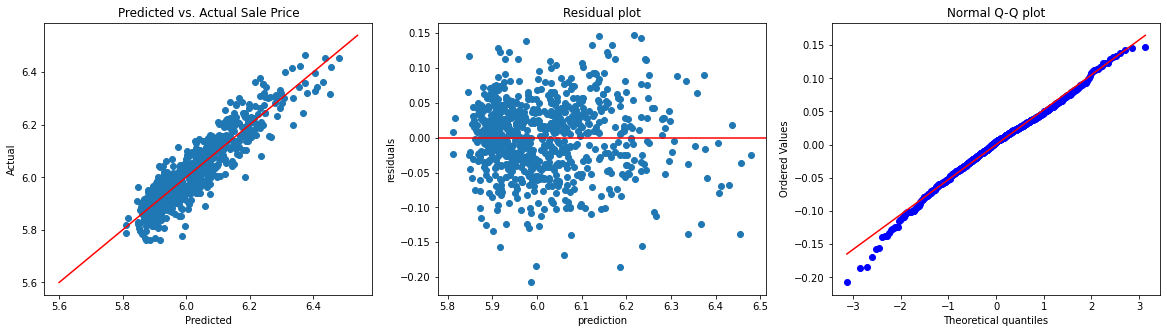

In [47]:
model_1c.fit(X_cv, y_cv)

y_pred = model_1c.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

### Model 2: Try adding some further features

#### 'beds', 'baths', 'hm_sqft', 'lot_size', 'schools' & 'yr_built' all show signs of a possible 2nd-order relationship w/ 'sold_price'

In [48]:
df_data['beds_SQ'] = df_data['beds'] * df_data['beds']
df_data['baths_SQ'] = df_data['baths'] * df_data['baths']
df_data['hm_sqft_SQ'] = df_data['hm_sqft'] * df_data['hm_sqft']
df_data['lot_size_SQ'] = df_data['lot_size'] * df_data['lot_size']
df_data['schools_SQ'] = df_data['schools'] * df_data['schools']
df_data['yr_built_SQ'] = df_data['yr_built'] * df_data['yr_built']

In [380]:
X2 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X2_cv, X2_test, y2_cv, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [381]:
model_2 = LinearRegression()

cv_rsquareds(X2_cv, y2_cv, model_2, 5)
cv_maes(X2_cv, y2_cv, model_2, 5)

CV R-squareds: [0.843, 0.861, 0.837, 0.815, 0.815]
Mean CV R-squared: 0.834 +/- 0.018

Adjusted CV R-squareds: [0.837, 0.856, 0.831, 0.808, 0.808]
Mean Adjusted CV R-squared: 0.828 +/- 0.018

CV MAEs: [106684, 99459, 106645, 106493, 112211]
Mean CV MAE: 106298 +/- 4051


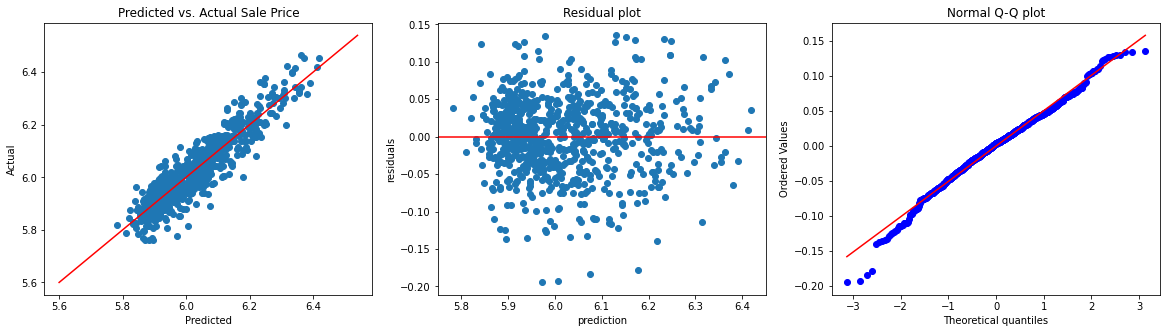

In [382]:
model_2.fit(X2_cv, y2_cv)

y2_pred = model_2.predict(X2_cv)

diagnostic_plots(X2_cv, y2_cv, y2_pred)

#### On an MAE basis, pretty good!

In [383]:
list(zip(X2_cv.columns, model_2.coef_))

[('beds', 0.01818011694926459),
 ('baths', 0.004402083722899872),
 ('hm_sqft', 0.00012384078106657113),
 ('lot_size', 1.2130651545462464e-05),
 ('yr_built', 0.05573180705087348),
 ('garage', 3.661558274361414e-05),
 ('one_story', 0.01558122094907946),
 ('schools', -0.0951276404434983),
 ('hoa', 8.662973918354498e-05),
 ('city_chatsworth', -0.029324799940041724),
 ('city_encino', 0.1393149257431437),
 ('city_granada_hills', -0.008815360939044545),
 ('city_lake_balboa', 0.026105782155876302),
 ('city_north_hills', -0.029751120795097556),
 ('city_northridge', -0.00317874585233207),
 ('city_porter_ranch', 0.006283902524509007),
 ('city_reseda', 0.012483802721403842),
 ('city_tarzana', 0.10454637838369112),
 ('city_west_hills', -0.016400833613178484),
 ('city_winnetka', -0.027604314401314306),
 ('city_woodland_hills', 0.05038713702017911),
 ('beds_SQ', -0.0026268501797978325),
 ('baths_SQ', 0.00258395601030258),
 ('hm_sqft_SQ', -8.59631578686024e-09),
 ('lot_size_SQ', -1.942796201692687e-10

In [384]:
var_magnitudes = sorted(list(zip(X2_cv.columns, model_2.coef_)), key=lambda x: x[1])

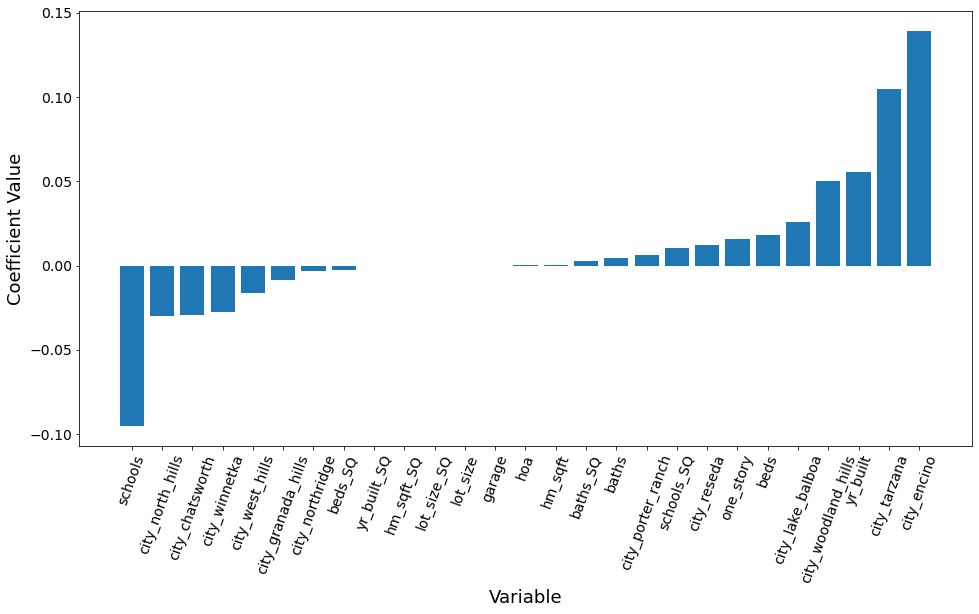

In [385]:
plt.figure(figsize=(16,8))
plt.bar(range(len(var_magnitudes)), [val[1] for val in var_magnitudes], align='center')
plt.xticks(range(len(var_magnitudes)), [val[0] for val in var_magnitudes])
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Variable', fontsize=18)
plt.ylabel('Coefficient Value', fontsize=18)
plt.show()

In [373]:
X2_cv.loc[0]

beds                          4.00
baths                         3.00
hm_sqft                    1933.00
lot_size                   6999.00
yr_built                   1960.00
garage                        1.00
one_story                     1.00
schools                       6.40
hoa                           0.00
city_chatsworth               0.00
city_encino                   0.00
city_granada_hills            0.00
city_lake_balboa              0.00
city_north_hills              0.00
city_northridge               0.00
city_porter_ranch             0.00
city_reseda                   0.00
city_tarzana                  0.00
city_west_hills               0.00
city_winnetka                 0.00
city_woodland_hills           1.00
beds_SQ                      16.00
baths_SQ                      9.00
hm_sqft_SQ              3736489.00
lot_size_SQ            48986001.00
schools_SQ                   40.96
yr_built_SQ             3841600.00
Name: 0, dtype: float64

In [374]:
coeffs = [val[1] for val in list(zip(X2_cv.columns, model_2.coef_))]
pred = []
for n in range(len(X2_cv.loc[0])):
    pred.append(X2_cv.loc[0][n] * coeffs[n])
print('Actual: {}'.format(10**y[0]))   
print('Predicted: {}'.format(10**(np.sum(pred) + model_2.intercept_)))

Actual: 970000.0000000008
Predicted: 1114099.9284875838


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

### Model 3: Try "Lazy" Lasso (specifically to eliminate some predictors)

In [330]:
X3 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [331]:
alphas = 10**np.linspace(-4, 4, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=100000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 4)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0003


In [332]:
model_3 = Lasso(alpha=0.0003, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.851, 0.861, 0.837, 0.811, 0.814]
Mean CV R-squared: 0.835 +/- 0.02

Adjusted CV R-squareds: [0.846, 0.856, 0.831, 0.804, 0.807]
Mean Adjusted CV R-squared: 0.829 +/- 0.021

CV MAEs: [103946, 98254, 107882, 108619, 113965]
Mean CV MAE: 106533 +/- 5228


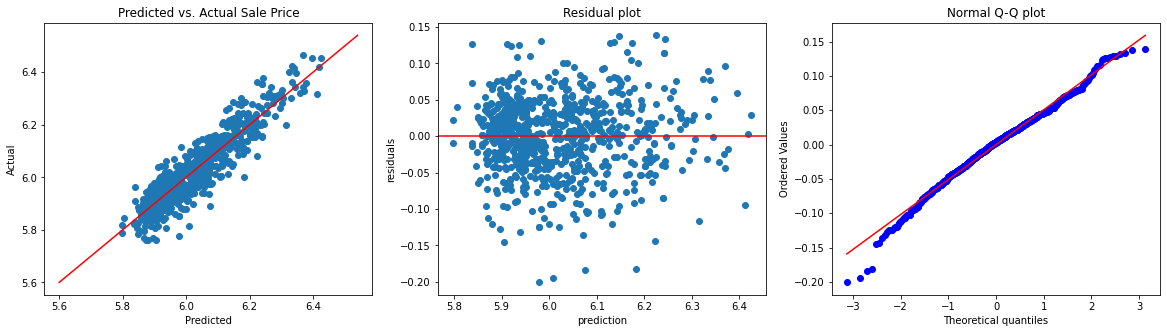

In [333]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, y3_cv, y3_pred)

#### On a Mean MAE basis, not quite as good as Model 2

In [335]:
list(zip(X3_cv.columns, model_3.coef_))

[('beds', 0.0),
 ('baths', 0.01528950491919591),
 ('hm_sqft', 0.08441067158128578),
 ('lot_size', 0.05617720790780963),
 ('yr_built', 0.003633597351100665),
 ('garage', 0.0),
 ('one_story', 0.004893371424769217),
 ('schools', 0.0),
 ('hoa', 0.0014408149238255476),
 ('city_chatsworth', -0.006203777439964781),
 ('city_encino', 0.031475298238633743),
 ('city_granada_hills', -0.004650147199841953),
 ('city_lake_balboa', 0.0037606423640696844),
 ('city_north_hills', -0.009023056038017355),
 ('city_northridge', -0.0018633723257316347),
 ('city_porter_ranch', 0.0),
 ('city_reseda', 0.001971204536202452),
 ('city_tarzana', 0.01904429710021828),
 ('city_west_hills', -0.004366907262476231),
 ('city_winnetka', -0.004529405740940506),
 ('city_woodland_hills', 0.018239711633899484),
 ('beds_SQ', -0.001763770169271426),
 ('baths_SQ', 0.0),
 ('hm_sqft_SQ', -0.023847256404630042),
 ('lot_size_SQ', -0.027391747575130413),
 ('schools_SQ', 0.018651424399102834),
 ('yr_built_SQ', 0.0)]

#### Only a few got driven to zero; can't drop schools since schools_SQ is non-zero; hardly seems worth dropping baths_SQ

### Model 4 - "Lazy" Ridge Regression

In [336]:
X4 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X4_cv, X4_test, y4_cv, y4_test = train_test_split(X4, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X4_cv_scaled = scaler.fit_transform(X4_cv)

In [337]:
alphas = np.linspace(0.0001, 10000, 1000)
ridge_model = RidgeCV(alphas=alphas, cv=5, normalize=False)

ridge_model.fit(X4_cv_scaled, y4_cv)

alpha = round(ridge_model.alpha_, 4)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0001


In [338]:
model_4 = Ridge(alpha=0.0001, max_iter=100000)

cv_rsquareds(X4_cv_scaled, y4_cv, model_4, 5)
cv_maes(X4_cv_scaled, y4_cv, model_4, 5)

CV R-squareds: [0.843, 0.861, 0.837, 0.815, 0.815]
Mean CV R-squared: 0.834 +/- 0.018

Adjusted CV R-squareds: [0.837, 0.856, 0.831, 0.808, 0.808]
Mean Adjusted CV R-squared: 0.828 +/- 0.018

CV MAEs: [106689, 99438, 106665, 106500, 112211]
Mean CV MAE: 106301 +/- 4058


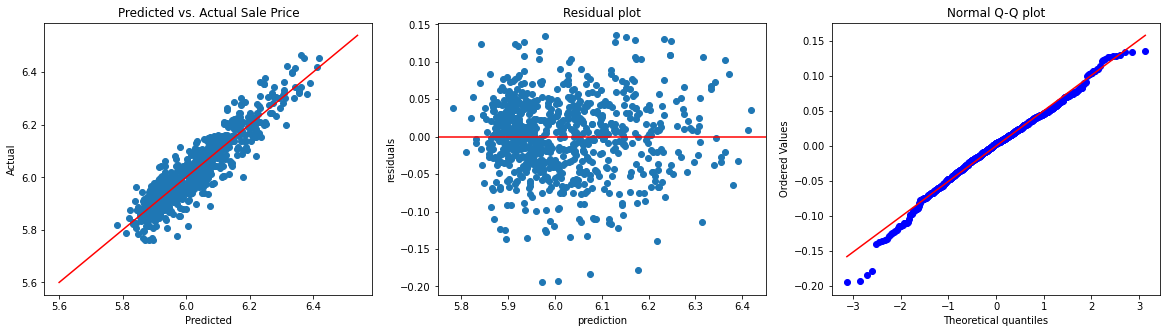

In [339]:
model_4.fit(X4_cv_scaled, y4_cv)

y4_pred = model_4.predict(X4_cv_scaled)

diagnostic_plots(X4_cv_scaled, y4_cv, y4_pred)

#### On a Mean MAE basis, nearly identical to Model 2

In [344]:
list(zip(X4_cv.columns, model_4.coef_))

[('beds', 0.015241171948555973),
 ('baths', 0.0036954775880068),
 ('hm_sqft', 0.0952669219472015),
 ('lot_size', 0.06103024516184005),
 ('yr_built', 0.5874839234330322),
 ('garage', 1.090862005029304e-05),
 ('one_story', 0.005923817038271493),
 ('schools', -0.06447875002483472),
 ('hoa', 0.0014199753788522414),
 ('city_chatsworth', -0.0058597756387745855),
 ('city_encino', 0.03418987423358281),
 ('city_granada_hills', -0.0027335366975445126),
 ('city_lake_balboa', 0.0064025264540031),
 ('city_north_hills', -0.007372019907225355),
 ('city_northridge', -0.0007898568094085596),
 ('city_porter_ranch', 0.0015411366820126944),
 ('city_reseda', 0.002826782229208099),
 ('city_tarzana', 0.02058131249078545),
 ('city_west_hills', -0.004238957392081739),
 ('city_winnetka', -0.005435253466762502),
 ('city_woodland_hills', 0.020813034710484558),
 ('beds_SQ', -0.018363604414547777),
 ('baths_SQ', 0.013904658162610403),
 ('hm_sqft_SQ', -0.0352327650425387),
 ('lot_size_SQ', -0.031880930460597),
 ('sc

In [345]:
var_magnitudes = sorted(list(zip(X4_cv.columns, model_4.coef_)), key=lambda x: x[1])

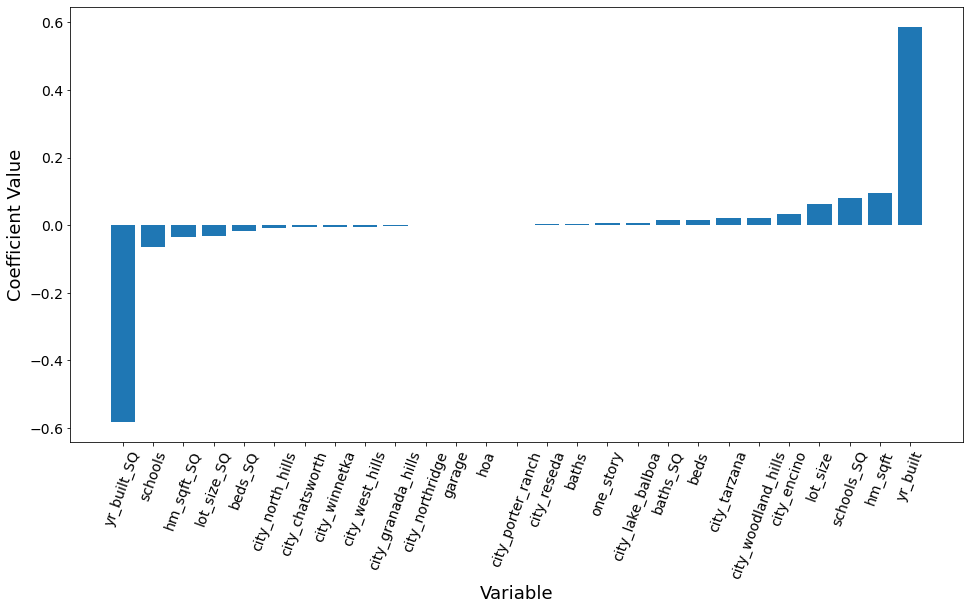

In [346]:
plt.figure(figsize=(16,8))
plt.bar(range(len(var_magnitudes)), [val[1] for val in var_magnitudes], align='center')
plt.xticks(range(len(var_magnitudes)), [val[0] for val in var_magnitudes])
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Variable', fontsize=18)
plt.ylabel('Coefficient Value', fontsize=18)
plt.show()

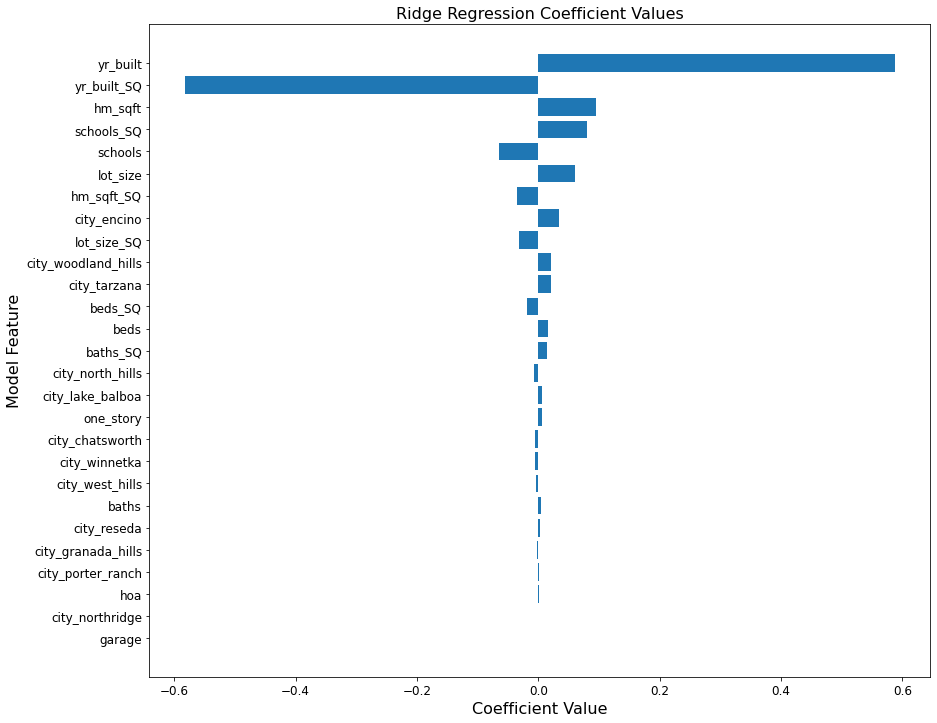

In [389]:
sorted_idx = np.abs(model_4.coef_).argsort()
plt.figure(figsize=(14, 12))
plt.barh(X4_cv.columns[sorted_idx], model_4.coef_[sorted_idx])
plt.title('Ridge Regression Coefficient Values', fontsize=16)
plt.xlabel("Coefficient Value", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

In [347]:
X4_cv_scaled[0]

array([ 0.42931084, -0.60768503, -0.60885113, -0.71414044, -0.95105616,
       -0.41214932,  0.46137155,  0.38386495, -0.11195354, -0.20851441,
       -0.26234693, -0.34673666,  3.81174655, -0.2650854 , -0.2650854 ,
       -0.26234693, -0.23960359, -0.20519567, -0.27847984, -0.20519567,
       -0.52866155,  0.29279106, -0.55725913, -0.556886  , -0.52544516,
        0.33233843, -0.94692463])

In [352]:
coeffs = [val[1] for val in list(zip(X4_cv.columns, model_4.coef_))]
pred = []
for n in range(len(X4_cv_scaled[0])):
    pred.append(X4_cv_scaled[0][n] * coeffs[n])
print('Actual: {}'.format(10**y[0]))   
print('Predicted: {}'.format(10**(np.sum(pred) + model_4.intercept_)))

Actual: 970000.0000000008
Predicted: 884136.3116306037


### Model 5 - "Lazy" ElasticNet Regression (all the variables in the model)

In [340]:
X5 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X5_cv, X5_test, y5_cv, y5_test = train_test_split(X5, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X5_cv_scaled = scaler.fit_transform(X5_cv)

In [341]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=1500000)

elastic_model.fit(X5_cv_scaled, y5_cv)

alpha = round(elastic_model.alpha_, 4)
print('Best alpha = {}'.format(alpha))
l1_ratio = round(elastic_model.l1_ratio_, 2)
print('Best L1 Ratio = {}'.format(l1_ratio))

Best alpha = 0.001
Best L1 Ratio = 0.3


In [342]:
model_5 = ElasticNet(alpha=0.001, l1_ratio=0.3, max_iter=1500000)

cv_rsquareds(X5_cv_scaled, y5_cv, model_5, 5)
cv_maes(X5_cv_scaled, y5_cv, model_5, 5)

CV R-squareds: [0.851, 0.861, 0.837, 0.81, 0.814]
Mean CV R-squared: 0.835 +/- 0.02

Adjusted CV R-squareds: [0.846, 0.856, 0.831, 0.803, 0.807]
Mean Adjusted CV R-squared: 0.829 +/- 0.021

CV MAEs: [103781, 98359, 107832, 108662, 114152]
Mean CV MAE: 106557 +/- 5266


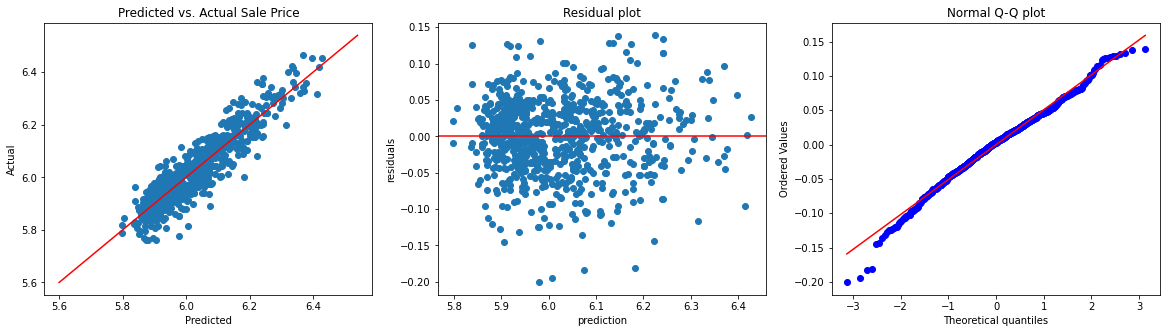

In [343]:
model_5.fit(X5_cv_scaled, y5_cv)

y5_pred = model_5.predict(X5_cv_scaled)

diagnostic_plots(X5_cv_scaled, y5_cv, y5_pred)

#### Not as good as Model 2 or Model 4!

### Model 6: Random Forest Regression

In [359]:
X6 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')
X6_cv, X6_test, y6_cv, y6_test = train_test_split(X6, y, test_size=0.2, random_state=42)

In [360]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 500, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X6_cv, y6_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [361]:
rf_gridsearch.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 100,
 'bootstrap': False}

In [362]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [700, 750, 800, 850, 900],
        'max_features': ['log2'],
        'max_depth': [95, 100, 110],
        'min_samples_split': [3, 4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [False]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X6_cv, y6_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [95, 100, 110],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [700, 750, 800, 850, 900]})

In [363]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 95,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 750}

In [364]:
model_6 = RandomForestRegressor(
    n_estimators=750,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=95,
    bootstrap=False
)

cv_rsquareds(X6_cv, y6_cv, model_6, 5)
cv_maes(X6_cv, y6_cv, model_6, 5)

CV R-squareds: [0.842, 0.846, 0.831, 0.737, 0.777]
Mean CV R-squared: 0.807 +/- 0.043

Adjusted CV R-squareds: [0.836, 0.841, 0.825, 0.728, 0.769]
Mean Adjusted CV R-squared: 0.8 +/- 0.044

CV MAEs: [105626, 101799, 108540, 125563, 124213]
Mean CV MAE: 113148 +/- 9830


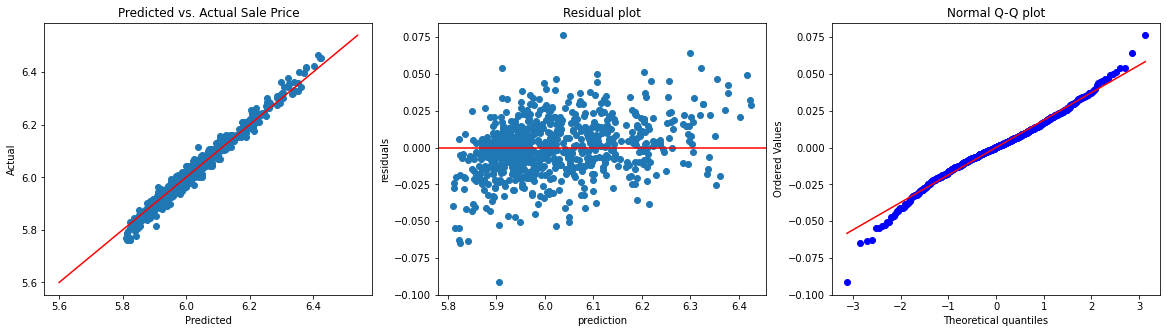

In [365]:
model_6.fit(X6_cv, y6_cv)

y6_pred = model_6.predict(X6_cv)

diagnostic_plots(X6_cv, y6_cv, y6_pred)

In [366]:
feature_importances = sorted(list(zip(X6_cv.columns, model_6.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft', 0.1874479562346582),
 ('hm_sqft_SQ', 0.17747169468675517),
 ('lot_size', 0.12081322224607019),
 ('lot_size_SQ', 0.11073195900639811),
 ('baths', 0.0717123966887767),
 ('baths_SQ', 0.07012053661188611),
 ('schools_SQ', 0.048245740554344566),
 ('schools', 0.04631615871482133),
 ('city_encino', 0.02312031951346668),
 ('yr_built', 0.022447465963945146),
 ('yr_built_SQ', 0.02225008177816341),
 ('city_woodland_hills', 0.02152462913694578),
 ('beds_SQ', 0.01937068821688158),
 ('beds', 0.01608709541168799),
 ('city_tarzana', 0.011448695210282652),
 ('city_north_hills', 0.00532797811508026),
 ('one_story', 0.005026776078796012),
 ('city_granada_hills', 0.0030918309972641704),
 ('city_winnetka', 0.0028562279813387163),
 ('city_porter_ranch', 0.0026376411783635176),
 ('city_northridge', 0.0023428331722799636),
 ('garage', 0.0020267721260081644),
 ('city_west_hills', 0.0019720423316457484),
 ('city_chatsworth', 0.0019161289225249167),
 ('city_lake_balboa', 0.0014119554323881749),
 ('c

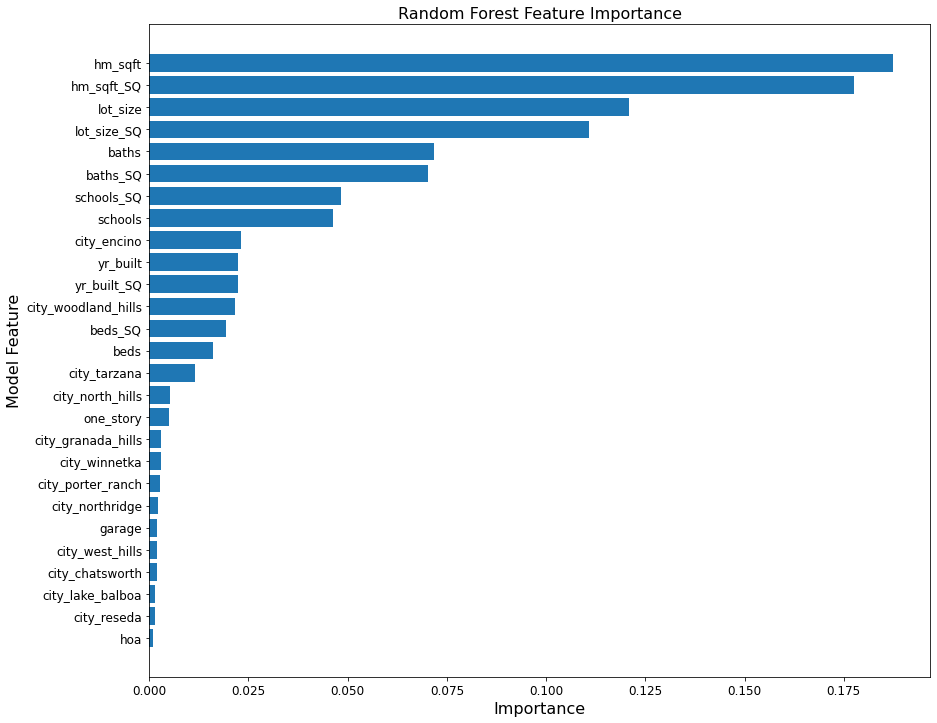

In [367]:
sorted_idx = model_6.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X6_cv.columns[sorted_idx], model_6.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

### Model 7 - XGBoost

In [368]:
X7 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')
X7_cv, X7_test, y7_cv, y7_test = train_test_split(X7, y, test_size=0.2, random_state=42)

In [369]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 2, 3, 5],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror', 'reg:pseudohubererror']
}

model_xgb = xgboost.XGBRegressor()

xgb_gridsearch = RandomizedSearchCV(estimator = model_xgb, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

xgb_gridsearch.fit(X7_cv, y7_cv)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [370]:
warnings.filterwarnings(action='ignore', category=UserWarning)
xgb_gridsearch.best_params_

{'subsample': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [371]:
warnings.filterwarnings(action='ignore', category=UserWarning)
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {
        'learning_rate': [0.005, 0.01, 0.02, 0.05],
        'max_depth': [1, 2, 3, 4],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.4, 0.5, 0.6],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'n_estimators' : [900, 1000, 1200],
        'objective': ['reg:squarederror']
}

# Perform grid search
grid_search = GridSearchCV(estimator = xgboost.XGBRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [372]:
warnings.filterwarnings(action='ignore', category=UserWarning)
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.02,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'subsample': 0.4}

In [375]:
# Need this to filter annoying warnings (known bug/'feature' of XGBoost)
warnings.filterwarnings(action='ignore', category=UserWarning)

# model_xgb = xgboost.XGBRegressor(objective='reg:pseudohubererror', random_state=42)
model_7 = xgboost.XGBRegressor(
        subsample=0.4,
        objective='reg:squarederror',
        n_estimators=1000,
        min_child_weight=1,
        max_depth=2,
        learning_rate=0.02,
        colsample_bytree=0.7
)

cv_rsquareds(X7_cv, y7_cv, model_7, 5)
cv_maes(X7_cv, y7_cv, model_7, 5)

CV R-squareds: [0.861, 0.867, 0.839, 0.801, 0.798]
Mean CV R-squared: 0.833 +/- 0.029

Adjusted CV R-squareds: [0.856, 0.862, 0.833, 0.794, 0.791]
Mean Adjusted CV R-squared: 0.827 +/- 0.03

CV MAEs: [98345, 92503, 104477, 109844, 118730]
Mean CV MAE: 104780 +/- 9083


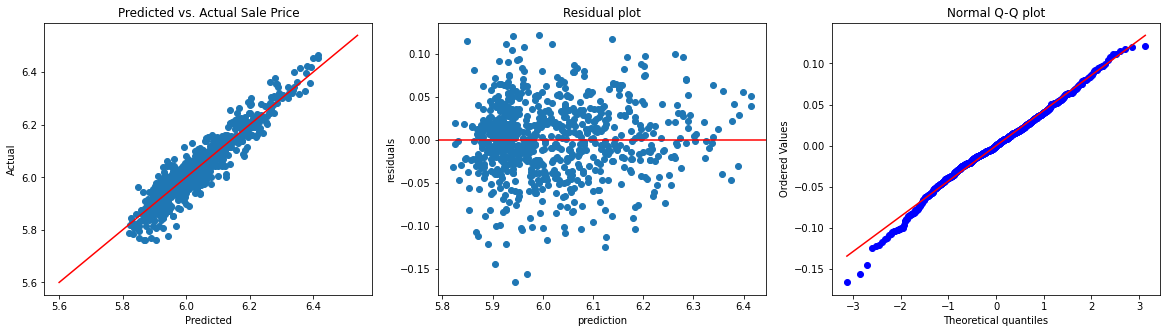

In [376]:
model_7.fit(X7_cv, y7_cv)

y7_pred = model_7.predict(X7_cv)

diagnostic_plots(X7_cv, y7_cv, y7_pred)

In [377]:
model_7.get_booster().get_score(importance_type="gain")

{'hm_sqft_SQ': 0.05513747079569534,
 'hm_sqft': 0.049229704808042965,
 'lot_size': 0.03013285434368395,
 'lot_size_SQ': 0.036701775567317595,
 'schools': 0.025653879651947233,
 'baths': 0.033689917612666646,
 'schools_SQ': 0.02204983661800001,
 'one_story': 0.012035714011428568,
 'city_encino': 0.04238887837454545,
 'city_granada_hills': 0.015375540901428574,
 'city_lake_balboa': 0.012203458333913042,
 'baths_SQ': 0.01952200956351351,
 'city_north_hills': 0.01753875052191489,
 'city_woodland_hills': 0.04526592516915943,
 'city_porter_ranch': 0.01075016537842105,
 'city_northridge': 0.00964148732125,
 'city_winnetka': 0.013062556822692308,
 'city_west_hills': 0.012556108230645166,
 'city_chatsworth': 0.013076598442400002,
 'city_tarzana': 0.028198753293663358,
 'yr_built': 0.010820698132990102,
 'beds': 0.009318600408589745,
 'yr_built_SQ': 0.009683670165242854,
 'beds_SQ': 0.01166645535647059,
 'garage': 0.009110712402727273,
 'city_reseda': 0.011377712156666667,
 'hoa': 0.00641401666}

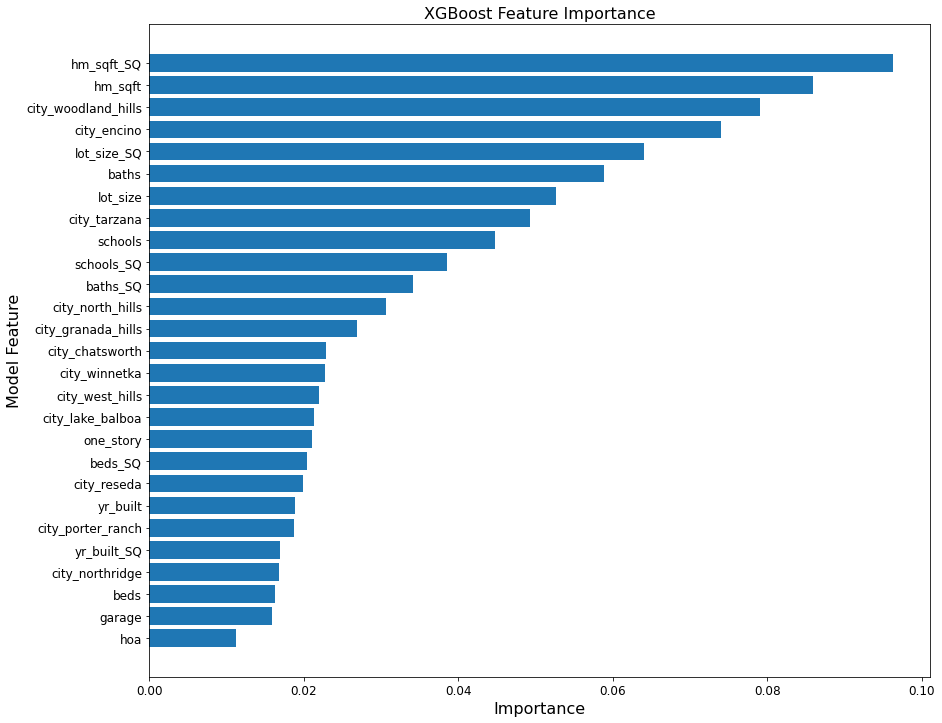

In [378]:
sorted_idx = model_7.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X7_cv.columns[sorted_idx], model_7.feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

In [379]:
feature_importances = sorted(list(zip(X7_cv.columns, model_7.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft_SQ', 0.09629262),
 ('hm_sqft', 0.08597524),
 ('city_woodland_hills', 0.07905286),
 ('city_encino', 0.07402835),
 ('lot_size_SQ', 0.06409634),
 ('baths', 0.0588364),
 ('lot_size', 0.05262431),
 ('city_tarzana', 0.04924658),
 ('schools', 0.04480219),
 ('schools_SQ', 0.03850805),
 ('baths_SQ', 0.03409343),
 ('city_north_hills', 0.030629845),
 ('city_granada_hills', 0.026851995),
 ('city_chatsworth', 0.0228371),
 ('city_winnetka', 0.022812579),
 ('city_west_hills', 0.021928111),
 ('city_lake_balboa', 0.02131224),
 ('one_story', 0.02101929),
 ('beds_SQ', 0.020374412),
 ('city_reseda', 0.019870147),
 ('yr_built', 0.018897373),
 ('city_porter_ranch', 0.018774195),
 ('yr_built_SQ', 0.016911658),
 ('city_northridge', 0.016837988),
 ('beds', 0.016274095),
 ('garage', 0.015911037),
 ('hoa', 0.011201502)]

### Model 8 - XGBoost (drop the squared terms)

In [52]:
X8 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X8.drop(columns=['beds_SQ', 'baths_SQ', 'hm_sqft_SQ', 'lot_size_SQ', 'schools_SQ', 'yr_built_SQ'],
        inplace=True)

X8_cv, X8_test, y8_cv, y8_test = train_test_split(X8, y, test_size=0.2, random_state=42)

In [54]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 2, 3, 5],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror', 'reg:pseudohubererror']
}

model_xgb = xgboost.XGBRegressor()

xgb_gridsearch = RandomizedSearchCV(estimator = model_xgb, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

xgb_gridsearch.fit(X8_cv, y8_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [55]:
warnings.filterwarnings(action='ignore', category=UserWarning)
xgb_gridsearch.best_params_

{'subsample': 0.7,
 'objective': 'reg:pseudohubererror',
 'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [56]:
warnings.filterwarnings(action='ignore', category=UserWarning)
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {
        'learning_rate': [0.005, 0.01, 0.02, 0.05],
        'max_depth': [4, 5, 6],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'n_estimators' : [900, 1000, 1200],
        'objective': ['reg:pseudohubererror']
}

# Perform grid search
grid_search = GridSearchCV(estimator = xgboost.XGBRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X8_cv, y8_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [57]:
warnings.filterwarnings(action='ignore', category=UserWarning)
grid_search.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'objective': 'reg:pseudohubererror',
 'subsample': 0.6}

In [58]:
# Need this to filter annoying warnings (known bug/'feature' of XGBoost)
warnings.filterwarnings(action='ignore', category=UserWarning)

# model_xgb = xgboost.XGBRegressor(objective='reg:pseudohubererror', random_state=42)
model_8 = xgboost.XGBRegressor(
        subsample=0.6,
        objective='reg:pseudohubererror',
        n_estimators=1000,
        min_child_weight=1,
        max_depth=4,
        learning_rate=0.01,
        colsample_bytree=0.6
)

cv_rsquareds(X8_cv, y8_cv, model_8, 5)
cv_maes(X8_cv, y8_cv, model_8, 5)

CV R-squareds: [0.857, 0.874, 0.84, 0.798, 0.79]
Mean CV R-squared: 0.832 +/- 0.033

Adjusted CV R-squareds: [0.853, 0.871, 0.836, 0.792, 0.784]
Mean Adjusted CV R-squared: 0.827 +/- 0.034

CV MAEs: [99693, 89779, 104729, 110598, 121137]
Mean CV MAE: 105187 +/- 10502


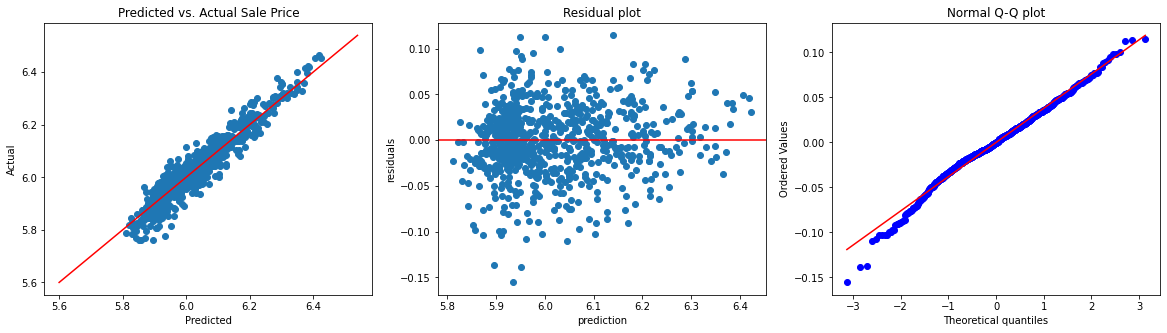

In [59]:
model_8.fit(X8_cv, y8_cv)

y8_pred = model_8.predict(X8_cv)

diagnostic_plots(X8_cv, y8_cv, y8_pred)

In [60]:
model_8.get_booster().get_score(importance_type="gain")

{'hm_sqft': 0.030448015716291122,
 'lot_size': 0.017509705835912322,
 'schools': 0.015009985677768222,
 'baths': 0.01717883752242456,
 'city_woodland_hills': 0.036153100519736414,
 'city_encino': 0.035028357581414364,
 'city_tarzana': 0.023768491431188282,
 'city_north_hills': 0.012048038344015148,
 'city_granada_hills': 0.008417035551518987,
 'beds': 0.005280328515795665,
 'city_winnetka': 0.007796156740548387,
 'city_northridge': 0.005614150668500001,
 'yr_built': 0.005105686463050068,
 'city_chatsworth': 0.008396022704141413,
 'city_west_hills': 0.007721879777022388,
 'city_porter_ranch': 0.0063760785545744665,
 'one_story': 0.005793359252657744,
 'city_lake_balboa': 0.006509076224365079,
 'city_reseda': 0.00560587083375,
 'garage': 0.004660545232899999,
 'hoa': 0.003322349031946511}

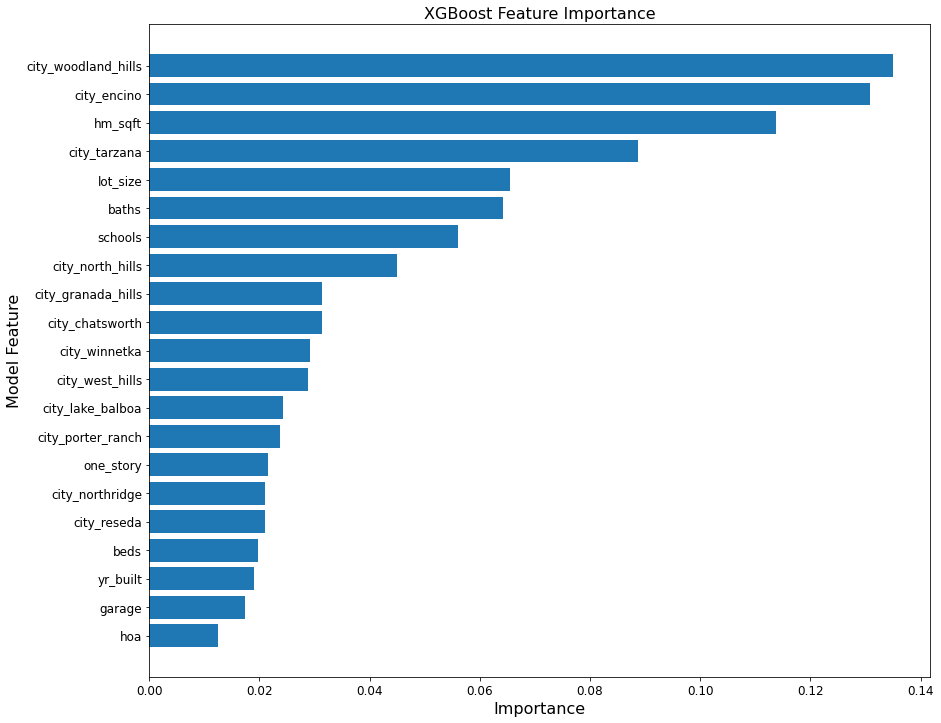

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [61]:
sorted_idx = model_8.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X8_cv.columns[sorted_idx], model_8.feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

In [379]:
feature_importances = sorted(list(zip(X8_cv.columns, model_8.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft_SQ', 0.09629262),
 ('hm_sqft', 0.08597524),
 ('city_woodland_hills', 0.07905286),
 ('city_encino', 0.07402835),
 ('lot_size_SQ', 0.06409634),
 ('baths', 0.0588364),
 ('lot_size', 0.05262431),
 ('city_tarzana', 0.04924658),
 ('schools', 0.04480219),
 ('schools_SQ', 0.03850805),
 ('baths_SQ', 0.03409343),
 ('city_north_hills', 0.030629845),
 ('city_granada_hills', 0.026851995),
 ('city_chatsworth', 0.0228371),
 ('city_winnetka', 0.022812579),
 ('city_west_hills', 0.021928111),
 ('city_lake_balboa', 0.02131224),
 ('one_story', 0.02101929),
 ('beds_SQ', 0.020374412),
 ('city_reseda', 0.019870147),
 ('yr_built', 0.018897373),
 ('city_porter_ranch', 0.018774195),
 ('yr_built_SQ', 0.016911658),
 ('city_northridge', 0.016837988),
 ('beds', 0.016274095),
 ('garage', 0.015911037),
 ('hoa', 0.011201502)]

### Model 9: Random Forest Regression (drop squared features)

In [71]:
X9 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X9.drop(columns=['beds_SQ', 'baths_SQ', 'hm_sqft_SQ', 'lot_size_SQ', 'schools_SQ', 'yr_built_SQ'],
        inplace=True)

X9_cv, X9_test, y9_cv, y9_test = train_test_split(X9, y, test_size=0.2, random_state=42)

In [72]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 500, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X9_cv, y9_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [73]:
rf_gridsearch.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': False}

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  Fil

In [74]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [1500, 1600, 1700],
        'max_features': ['log2'],
        'max_depth': [15, 20, 25],
        'min_samples_split': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [False]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X9_cv, y9_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [15, 20, 25],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [1500, 1600, 1700]})

In [75]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1700}

In [76]:
model_9 = RandomForestRegressor(
    n_estimators=1700,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=15,
    bootstrap=False
)

cv_rsquareds(X9_cv, y9_cv, model_9, 5)
cv_maes(X9_cv, y9_cv, model_9, 5)

CV R-squareds: [0.847, 0.853, 0.842, 0.755, 0.788]
Mean CV R-squared: 0.817 +/- 0.039

Adjusted CV R-squareds: [0.843, 0.849, 0.838, 0.748, 0.782]
Mean Adjusted CV R-squared: 0.812 +/- 0.04

CV MAEs: [101311, 98228, 102740, 119102, 122274]
Mean CV MAE: 108731 +/- 9922


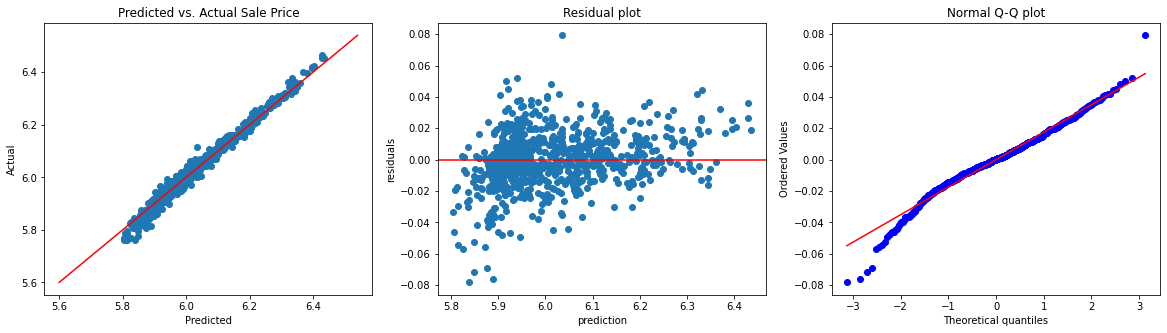

In [77]:
model_9.fit(X9_cv, y9_cv)

y9_pred = model_9.predict(X9_cv)

diagnostic_plots(X9_cv, y9_cv, y9_pred)

In [78]:
feature_importances = sorted(list(zip(X9_cv.columns, model_9.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft', 0.31688627959073995),
 ('lot_size', 0.2096056290447051),
 ('baths', 0.13909059783507416),
 ('schools', 0.09016202234169611),
 ('yr_built', 0.050910371023849536),
 ('beds', 0.04557931626831875),
 ('city_woodland_hills', 0.038524211770930766),
 ('city_encino', 0.03483899318554537),
 ('city_tarzana', 0.020120265235499497),
 ('one_story', 0.010510360328326472),
 ('city_north_hills', 0.009352370778589775),
 ('city_winnetka', 0.005378372002720544),
 ('city_granada_hills', 0.0049060757119424245),
 ('city_northridge', 0.0037378778933915423),
 ('garage', 0.003728965640114486),
 ('city_porter_ranch', 0.003632083208077028),
 ('city_west_hills', 0.0030823597781317108),
 ('city_chatsworth', 0.0028515171742233116),
 ('city_reseda', 0.00263795364006212),
 ('city_lake_balboa', 0.0023091744462233233),
 ('hoa', 0.002155203101837999)]

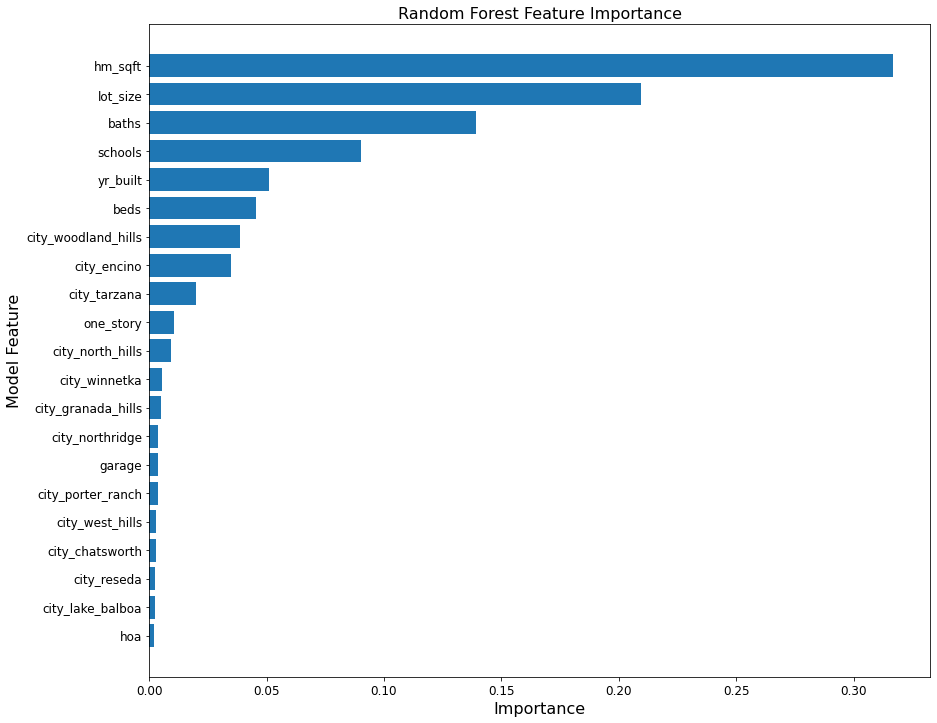

In [79]:
sorted_idx = model_9.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X9_cv.columns[sorted_idx], model_9.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');